In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy as scpy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from collections import Counter

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve

import warnings
warnings.filterwarnings('ignore')

#plt.style.use('fivethirtyeight')
sns.set_context("paper", font_scale=2)

## Basic functions

In [2]:
#Showing percentage of null values and number of unique values
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value, %'] = round(df.isnull().sum()/df.shape[0]*100)
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b

In [3]:
#Comparing average values from two dataframes
def basic_analysis(df1, df2):
    '''the function compares the average values of  2 dataframes'''
    b = pd.DataFrame()
    b['First df_mean'] = round(df1.mean(),2)
    b['Second df_mean'] = round(df2.mean(),2)
    c = (b['First df_mean']/b['Second df_mean'])
    if [c<=1]:
        b['Variation, %'] = round((1-((b['First df_mean']/b['Second df_mean'])))*100)
    else:
        b['Variation, %'] = round(((b['First df_mean']/b['Second df_mean'])-1)*100)
        
    b['Influence'] = np.where(abs(b['Variation, %']) <= 9, "feature's effect on the target is not defined", 
                              "feature value affects the target")

    return b

In [4]:
def reduce_memory_usage(df):
    """ The function will reduce memory of dataframe
    Note: Apply this function after removing missing value"""
    intial_memory = df.memory_usage().sum()/1024**2
    print('Intial memory usage:',intial_memory,'MB')
    for col in df.columns:
        mn = df[col].min()
        mx = df[col].max()
        if df[col].dtype != object:            
            if df[col].dtype == int:
                if mn >=0:
                    if mx < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif mx < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            if df[col].dtype == float:
                df[col] =df[col].astype(np.float32)
    
    red_memory = df.memory_usage().sum()/1024**2
    print('Memory usage after complition: ',red_memory,'MB')

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure(figsize = (10,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers  

## Loading data

In [7]:
# path to train dataset
train_path = 'titanic/train.csv'
# path to test dataset
test_path = 'titanic/test.csv'

# Read a comma-separated values (csv) file into pandas DataFrame
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

## thanks to @Nadezda Demidova  https://www.kaggle.com/demidova/titanic-eda-tutorial-with-seaborn
train_data.loc[train_data['PassengerId'] == 631, 'Age'] = 48

# Passengers with wrong number of siblings and parch
train_data.loc[train_data['PassengerId'] == 69, ['SibSp', 'Parch']] = [0,0]
test_data.loc[test_data['PassengerId'] == 1106, ['SibSp', 'Parch']] = [0,0]

# shape of tha data
print('Train shape: ', train_data.shape)
print('Test shape: ', test_data.shape)

# Concatenate pandas objects along a particular axis 
all_data = pd.concat([train_data, test_data], sort = False).reset_index(drop=True)
# shape of the data
print('All data shape: ', all_data.shape)
# Show first 4 rows of the concatenated DataFrame
all_data.head(4)

Train shape:  (891, 12)
Test shape:  (418, 11)
All data shape:  (1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [8]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [9]:
basic_details(test_data)

,"Missing value, %",N unique value,dtype
PassengerId,0.0,418,int64
Pclass,0.0,3,int64
Name,0.0,418,object
Sex,0.0,2,object
Age,21.0,79,float64
SibSp,0.0,7,int64
Parch,0.0,8,int64
Ticket,0.0,363,object
Fare,0.0,169,float64
Cabin,78.0,76,object


In [10]:
print(train_data['Survived'].value_counts(normalize = True))
# checking for Survived dependence of Sex feature
train_data[['Sex','Survived']].groupby(['Sex'], as_index=False).mean()

0    0.616162
1    0.383838
Name: Survived, dtype: float64


,Sex,Survived
0,female,0.742038
1,male,0.188908


## Detect outliers

In [11]:
Outliers_to_drop = detect_outliers(train_data,2,["Age","SibSp","Parch","Fare"])

In [12]:
train_data.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [13]:
# Drop outliers
train_data = train_data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## Feature analysis

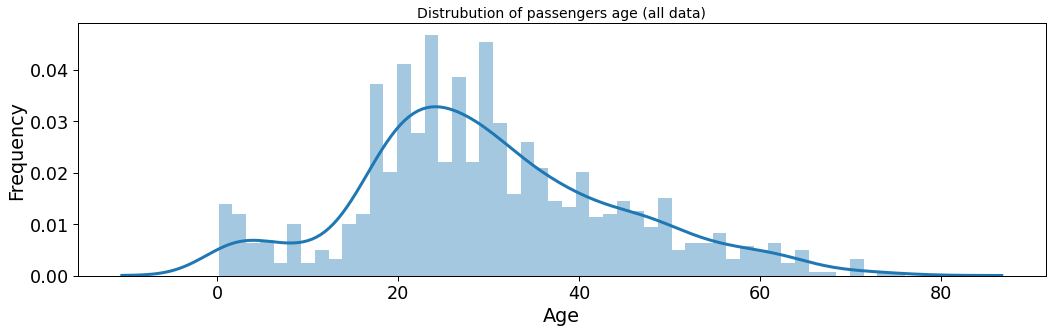

In [14]:
# set plot size
plt.figure(figsize=(15, 5))

# plot a univariate distribution of Age observations 
sns.distplot(all_data[(all_data["Age"] > 0)].Age, kde_kws={"lw": 3}, bins = 50)

# set titles and labels
plt.title('Distrubution of passengers age (all data)',fontsize= 14)
plt.xlabel('Age')
plt.ylabel('Frequency')
# clean layout
plt.tight_layout()

In [15]:
# Descriptive statistics include those that summarize the central tendency, 
# dispersion and shape of a dataset’s distribution, excluding NaN values.
age_distr = pd.DataFrame(all_data['Age'].describe())
# Transpose index and columns.
age_distr.transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1046.0,29.850545,14.340791,0.17,21.0,28.0,39.0,76.0


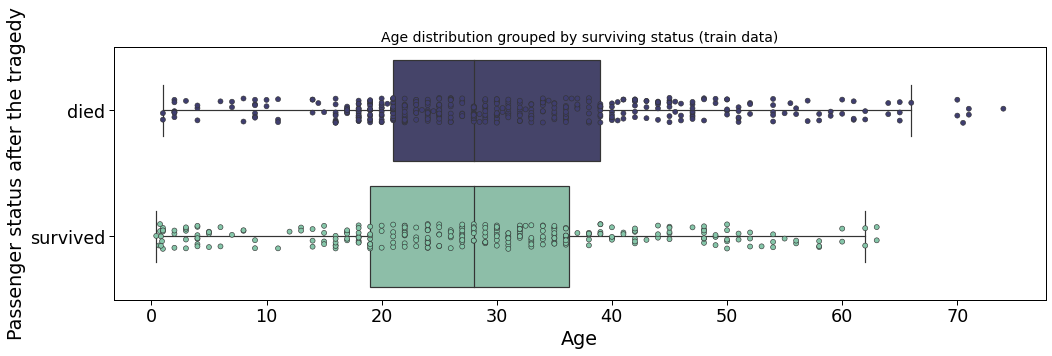

In [16]:
plt.figure(figsize=(15, 5))

# Draw a box plot to show Age distributions with respect to survival status.
sns.boxplot(y = 'Survived', x = 'Age', data = train_data,
     palette=["#3f3e6fd1", "#85c6a9"], fliersize = 0, orient = 'h')

# Add a scatterplot for each category.
sns.stripplot(y = 'Survived', x = 'Age', data = train_data,
     linewidth = 0.6, palette=["#3f3e6fd1", "#85c6a9"], orient = 'h')

plt.yticks( np.arange(2), ['died', 'survived'])
plt.title('Age distribution grouped by surviving status (train data)',fontsize= 14)
plt.ylabel('Passenger status after the tragedy')
plt.tight_layout()

In [17]:
# Descriptive statistics:
pd.DataFrame(all_data.groupby('Survived')['Age'].describe())

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0.0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1.0,290.0,28.233345,14.684091,0.42,19.0,28.0,36.0,63.0


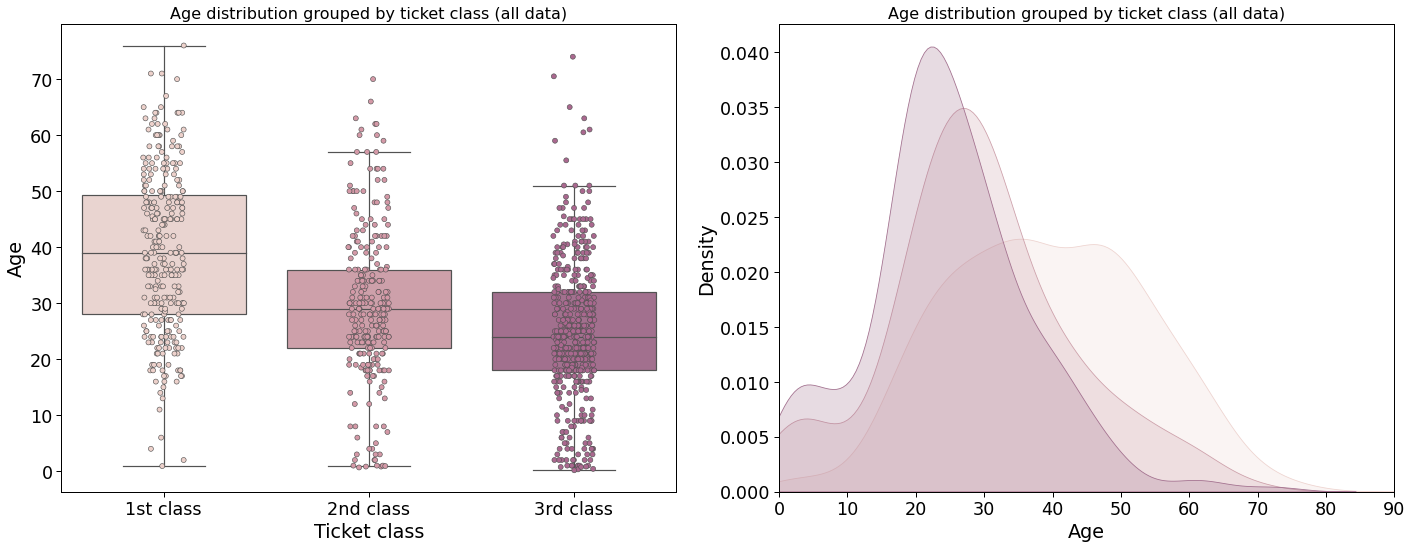

In [18]:
#Age by class

# set size
plt.figure(figsize=(20, 8))

# set palette
palette = sns.cubehelix_palette(5, start = 3)

plt.subplot(1, 2, 1)
sns.boxplot(x = 'Pclass', y = 'Age', data = all_data,
     palette = palette, fliersize = 0)

sns.stripplot(x = 'Pclass', y = 'Age', data = all_data,
     linewidth = 0.6, palette = palette)
plt.xticks( np.arange(3), ['1st class', '2nd class', '3rd class'])
plt.title('Age distribution grouped by ticket class (all data)',fontsize= 16)
plt.xlabel('Ticket class')


plt.subplot(1, 2, 2)

# To use kdeplot I need to create variables with filtered data for each category
age_1_class = all_data[(all_data["Age"] > 0) & 
                              (all_data["Pclass"] == 1)]
age_2_class = all_data[(all_data["Age"] > 0) & 
                              (all_data["Pclass"] == 2)]
age_3_class = all_data[(all_data["Age"] > 0) & 
                              (all_data["Pclass"] == 3)]

# Ploting the 3 variables that we create
sns.kdeplot(age_1_class["Age"], shade=True, color='#eed4d0', label = '1st class')
sns.kdeplot(age_2_class["Age"], shade=True,  color='#cda0aa', label = '2nd class')
sns.kdeplot(age_3_class["Age"], shade=True,color='#a2708e', label = '3rd class')
plt.title('Age distribution grouped by ticket class (all data)',fontsize= 16)
plt.xlabel('Age')
plt.xlim(0, 90)
plt.tight_layout()
plt.show()

In [19]:
# Descriptive statistics:
pd.DataFrame(all_data.groupby('Pclass')['Age'].describe())

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,284.0,39.047254,14.353217,0.92,28.0,39.0,49.25,76.0
2,261.0,29.506705,13.638627,0.67,22.0,29.0,36.00,70.0
3,501.0,24.816367,11.958202,0.17,18.0,24.0,32.00,74.0


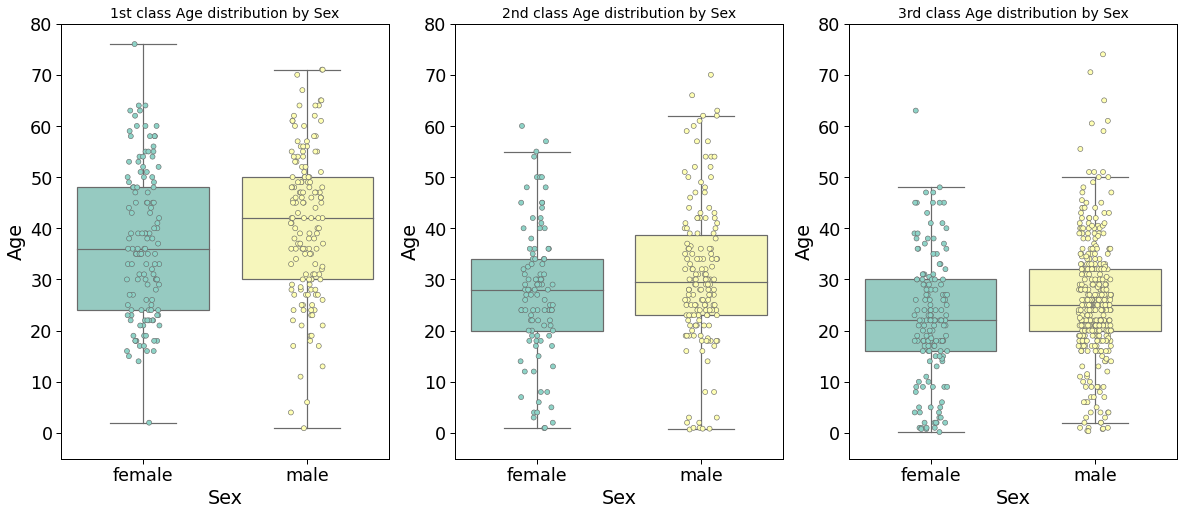

In [20]:
#Age vs class vs gender

plt.figure(figsize=(20, 8))
palette = "Set3"

plt.subplot(1, 3, 1)
sns.boxplot(x = 'Sex', y = 'Age', data = age_1_class,
     palette = palette, fliersize = 0)
sns.stripplot(x = 'Sex', y = 'Age', data = age_1_class,
     linewidth = 0.6, palette = palette)
plt.title('1st class Age distribution by Sex',fontsize= 14)
plt.ylim(-5, 80)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'Sex', y = 'Age', data = age_2_class,
     palette = palette, fliersize = 0)
sns.stripplot(x = 'Sex', y = 'Age', data = age_2_class,
     linewidth = 0.6, palette = palette)
plt.title('2nd class Age distribution by Sex',fontsize= 14)
plt.ylim(-5, 80)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'Sex', y = 'Age',  data = age_3_class,
     order = ['female', 'male'], palette = palette, fliersize = 0)
sns.stripplot(x = 'Sex', y = 'Age', data = age_3_class,
     order = ['female', 'male'], linewidth = 0.6, palette = palette)
plt.title('3rd class Age distribution by Sex',fontsize= 14)
plt.ylim(-5, 80)

plt.show()

In [21]:
# Descriptive statistics:
age_1_class_stat = pd.DataFrame(age_1_class.groupby('Sex')['Age'].describe())
age_2_class_stat = pd.DataFrame(age_2_class.groupby('Sex')['Age'].describe())
age_3_class_stat = pd.DataFrame(age_3_class.groupby('Sex')['Age'].describe())

pd.concat([age_1_class_stat, age_2_class_stat, age_3_class_stat], axis=0, sort = False, keys = ['1st', '2nd', '3rd'])

count       mean        std   min   25%   50%    75%   max
    Sex                                                               
1st female  133.0  37.037594  14.272460  2.00  24.0  36.0  48.00  76.0
    male    151.0  40.817351  14.236835  0.92  30.0  42.0  50.00  71.0
2nd female  103.0  27.499223  12.911747  0.92  20.0  28.0  34.00  60.0
    male    158.0  30.815380  13.977400  0.67  23.0  29.5  38.75  70.0
3rd female  152.0  22.185329  12.205254  0.17  16.0  22.0  30.00  63.0
    male    349.0  25.962264  11.682415  0.33  20.0  25.0  32.00  74.0

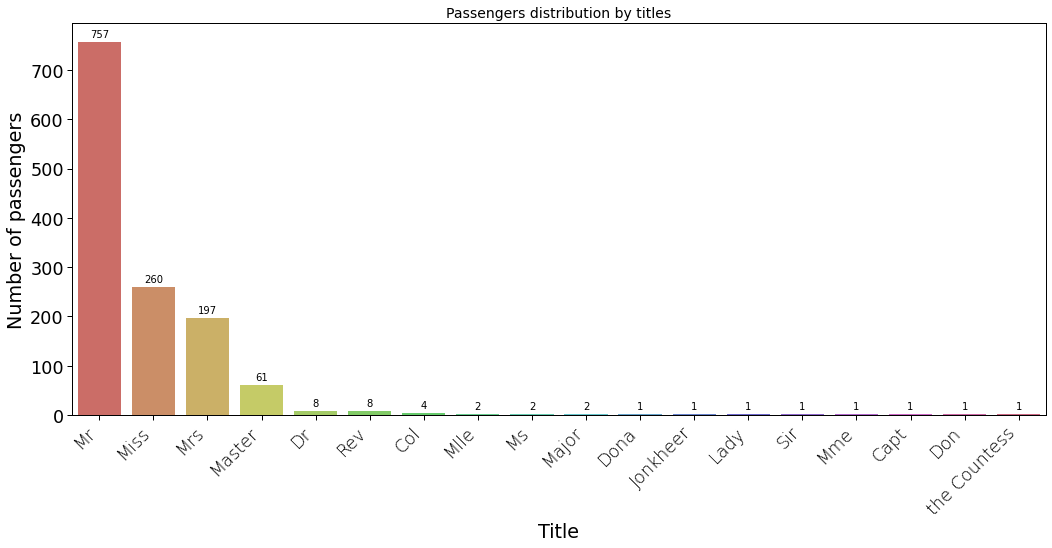

In [22]:
#Name

all_data['Title'] = all_data['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0].str.strip(' ')

plt.figure(figsize=(15, 8))
ax = sns.countplot( x = 'Title', data = all_data, palette = "hls", order = all_data['Title'].value_counts().index)
_ = plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)

plt.title('Passengers distribution by titles',fontsize= 14)
plt.ylabel('Number of passengers')

# calculate passengers for each category
labels = (all_data['Title'].value_counts())
# add result numbers on barchart
for i, v in enumerate(labels):
    ax.text(i, v+10, str(v), horizontalalignment = 'center', size = 10, color = 'black')
    

plt.tight_layout()
plt.show()

In [23]:
title_dict = {  'Mr':     'Mr',
                'Mrs':    'Mrs',
                'Miss':   'Miss',
                'Master': 'Master',
              
                'Ms':     'Miss',
                'Mme':    'Mrs',
                'Mlle':   'Miss',

                'Capt':   'military',
                'Col':    'military',
                'Major':  'military',

                'Dr':     'Dr',
                'Rev':    'Rev',
                  
                'Sir':    'honor',
                'the Countess': 'honor',
                'Lady':   'honor',
                'Jonkheer': 'honor',
                'Don':    'honor',
                'Dona':   'honor' }

# map titles to category
all_data['Title_category'] = all_data['Title'].map(title_dict)

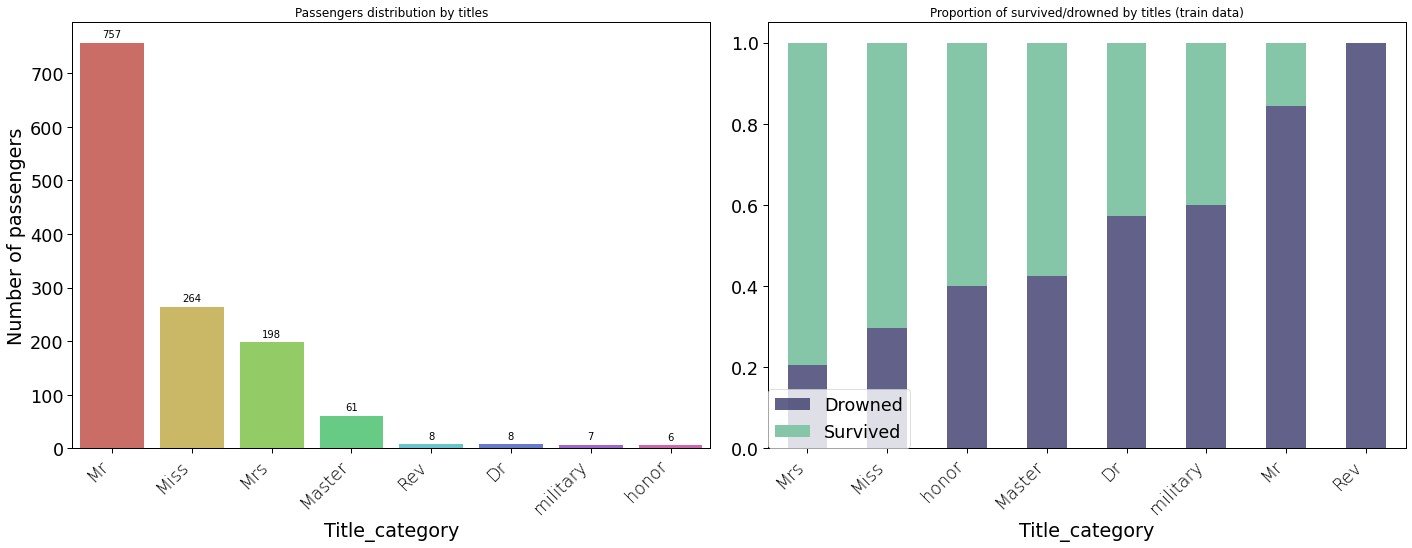

In [24]:
fig = plt.figure(figsize=(20, 8))


ax1 = fig.add_subplot(121)
ax = sns.countplot(x = 'Title_category', data = all_data, palette = "hls", order = all_data['Title_category'].value_counts().index)
_ = plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Passengers distribution by titles',fontsize= 12)
plt.ylabel('Number of passengers')

# calculate passengers for each category
labels = (all_data['Title_category'].value_counts())
# add result numbers on barchart
for i, v in enumerate(labels):
    ax.text(i, v+10, str(v), horizontalalignment = 'center', size = 10, color = 'black')
    

plt.tight_layout()

ax2 = fig.add_subplot(122)
surv_by_title_cat = all_data.groupby('Title_category')['Survived'].value_counts(normalize = True).unstack()
surv_by_title_cat = surv_by_title_cat.sort_values(by=1, ascending = False)
surv_by_title_cat.plot(kind='bar', stacked='True', color=["#3f3e6fd1", "#85c6a9"], ax = ax2)

plt.legend( ( 'Drowned', 'Survived'), loc=(0,0))
_ = plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)


plt.title('Proportion of survived/drowned by titles (train data)',fontsize= 12)

plt.tight_layout()
plt.show()

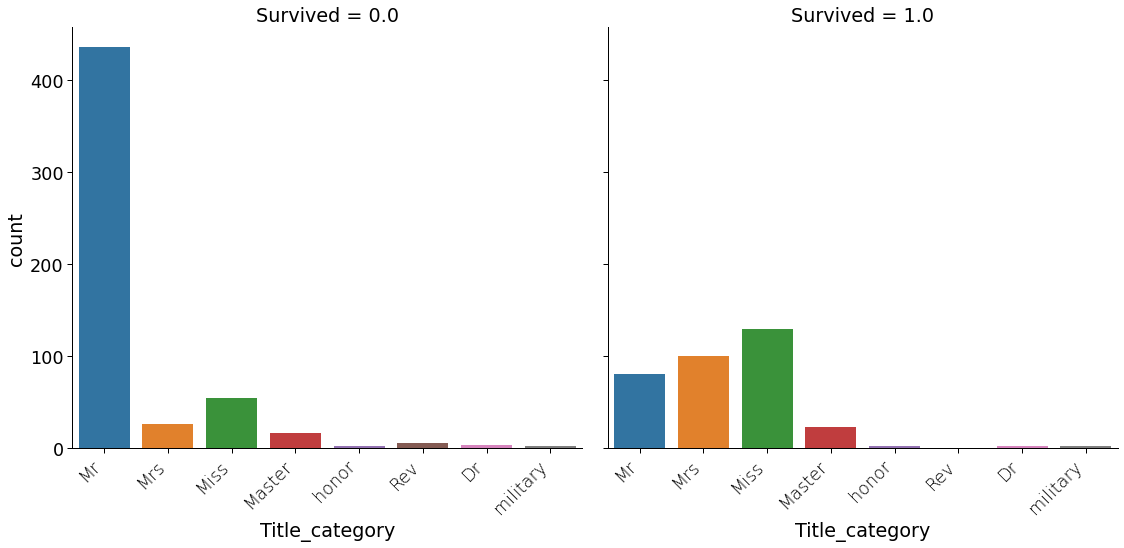

In [25]:
category_survived = sns.catplot(x="Title_category",  col="Survived",
                data = all_data, kind="count",
                height=8, aspect=1)

category_survived.set_xticklabels(rotation=45, 
    horizontalalignment='right',
    fontweight='light')

plt.tight_layout()
plt.show()

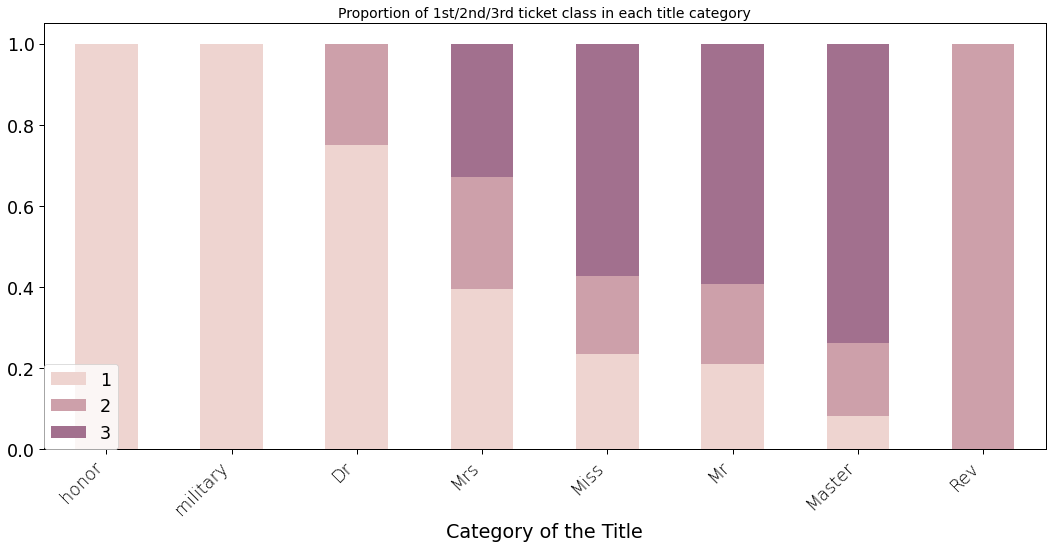

In [26]:
class_by_title_cat = all_data.groupby('Title_category')['Pclass'].value_counts(normalize = True)
class_by_title_cat = class_by_title_cat.unstack().sort_values(by = 1, ascending = False)
class_by_title_cat.plot(kind='bar', stacked='True', color = ['#eed4d0', '#cda0aa', '#a2708e'], figsize=(15,8))
plt.legend(loc=(0,0))
_ = plt.xticks(
    rotation = 45, 
    horizontalalignment = 'right',
    fontweight = 'light'
)


plt.title('Proportion of 1st/2nd/3rd ticket class in each title category',fontsize= 14)
plt.xlabel('Category of the Title')
plt.tight_layout()

In [27]:
all_data['deck'] = all_data['Cabin'].str.split('', expand = True)[1]
all_data.loc[all_data['deck'].isna(), 'deck'] = 'U'
print('Unique deck letters from the cabin numbers:', all_data['deck'].unique())

Unique deck letters from the cabin numbers: ['U' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


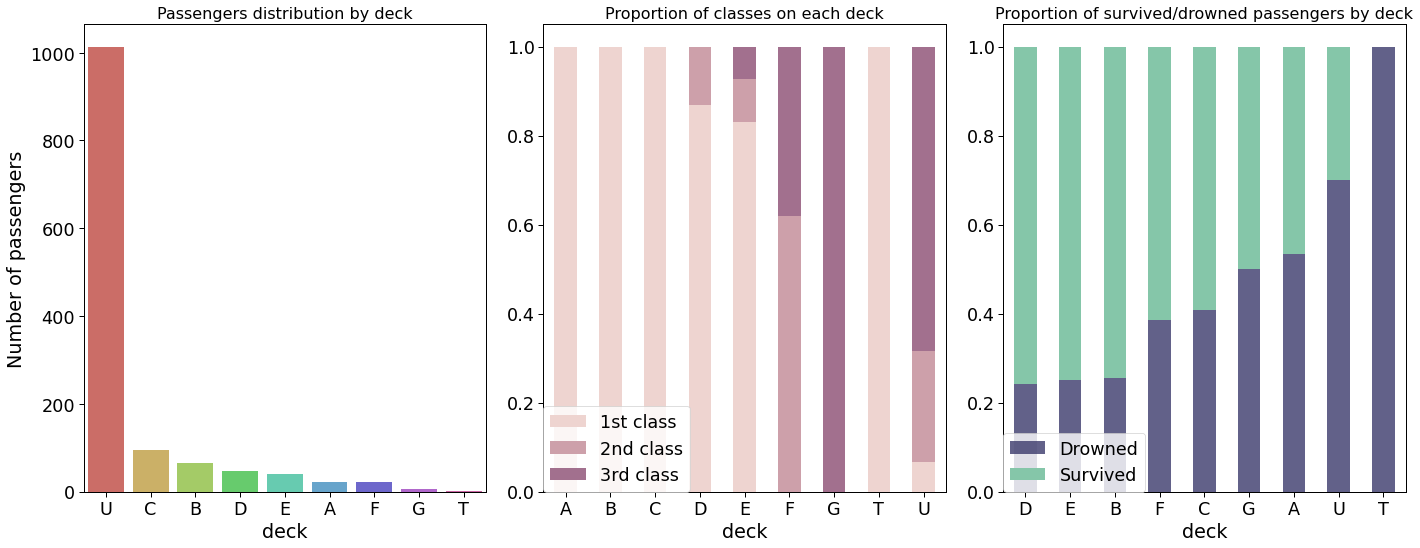

In [28]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(131)
sns.countplot(x = 'deck', data = all_data, palette = "hls", order = all_data['deck'].value_counts().index, ax = ax1)
plt.title('Passengers distribution by deck',fontsize= 16)
plt.ylabel('Number of passengers')

ax2 = fig.add_subplot(132)
deck_by_class = all_data.groupby('deck')['Pclass'].value_counts(normalize = True).unstack()
deck_by_class.plot(kind='bar', stacked='True',color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax2)
plt.legend(('1st class', '2nd class', '3rd class'), loc=(0,0))
plt.title('Proportion of classes on each deck',fontsize= 16)
plt.xticks(rotation = False)

ax3 = fig.add_subplot(133)
deck_by_survived = all_data.groupby('deck')['Survived'].value_counts(normalize = True).unstack()
deck_by_survived = deck_by_survived.sort_values(by = 1, ascending = False)
deck_by_survived.plot(kind='bar', stacked='True', color=["#3f3e6fd1", "#85c6a9"], ax = ax3)
plt.title('Proportion of survived/drowned passengers by deck',fontsize= 16)
plt.legend(( 'Drowned', 'Survived'), loc=(0,0))
plt.xticks(rotation = False)
plt.tight_layout()

plt.show()

In [29]:
all_data['Family_size'] = all_data['SibSp'] + all_data['Parch'] + 1
family_size = all_data['Family_size'].value_counts()
print('Family size and number of passengers:')
print(family_size)

Family size and number of passengers:
1     792
2     235
3     159
4      43
6      25
5      22
7      14
11     11
8       8
Name: Family_size, dtype: int64


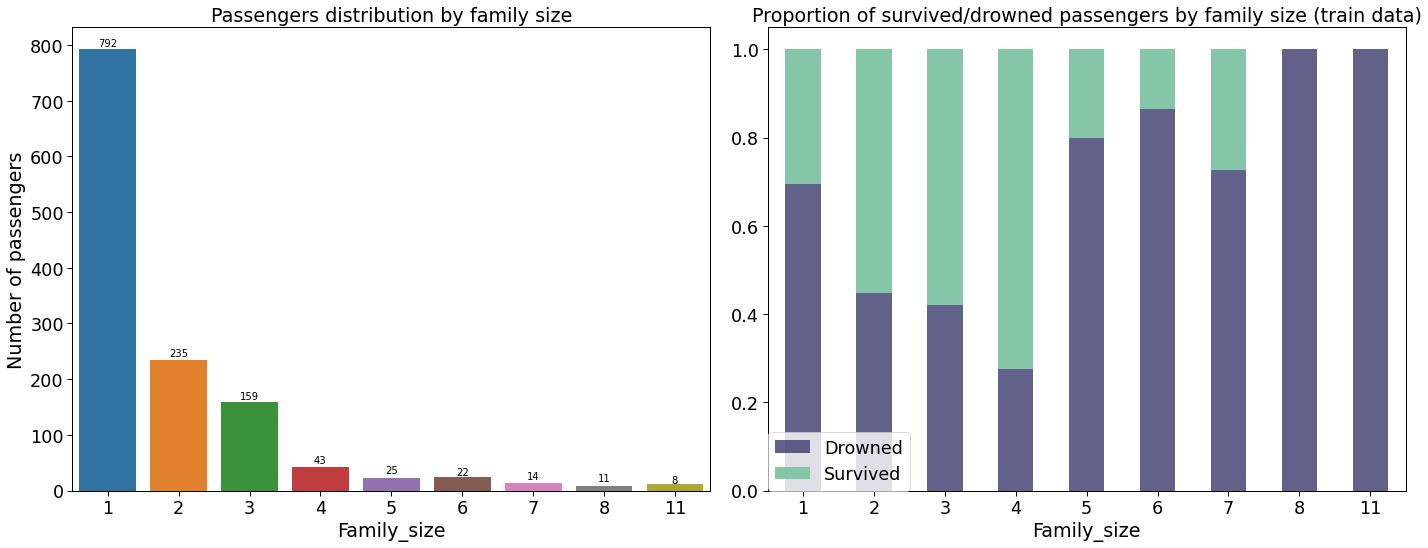

In [30]:
fig = plt.figure(figsize = (20,8))

ax1 = fig.add_subplot(121)
ax = sns.countplot(all_data['Family_size'], ax = ax1)

# calculate passengers for each category
labels = (all_data['Family_size'].value_counts())
# add result numbers on barchart
for i, v in enumerate(labels):
    ax.text(i, v+6, str(v), horizontalalignment = 'center', size = 10, color = 'black')
    
plt.title('Passengers distribution by family size')
plt.ylabel('Number of passengers')

ax2 = fig.add_subplot(122)
d = all_data.groupby('Family_size')['Survived'].value_counts(normalize = True).unstack()
d.plot(kind='bar', color=["#3f3e6fd1", "#85c6a9"], stacked='True', ax = ax2)
plt.title('Proportion of survived/drowned passengers by family size (train data)')
plt.legend(( 'Drowned', 'Survived'), loc=(0,0))
plt.xticks(rotation = False)

plt.tight_layout()

In [31]:
all_data['Family_size_group'] = all_data['Family_size'].map(lambda x: 'f_single' if x == 1 
                                                            else ('f_usual' if 5 > x >= 2 
                                                                  else ('f_big' if 8 > x >= 5 
                                                                       else 'f_large' )
                                                                 ))          

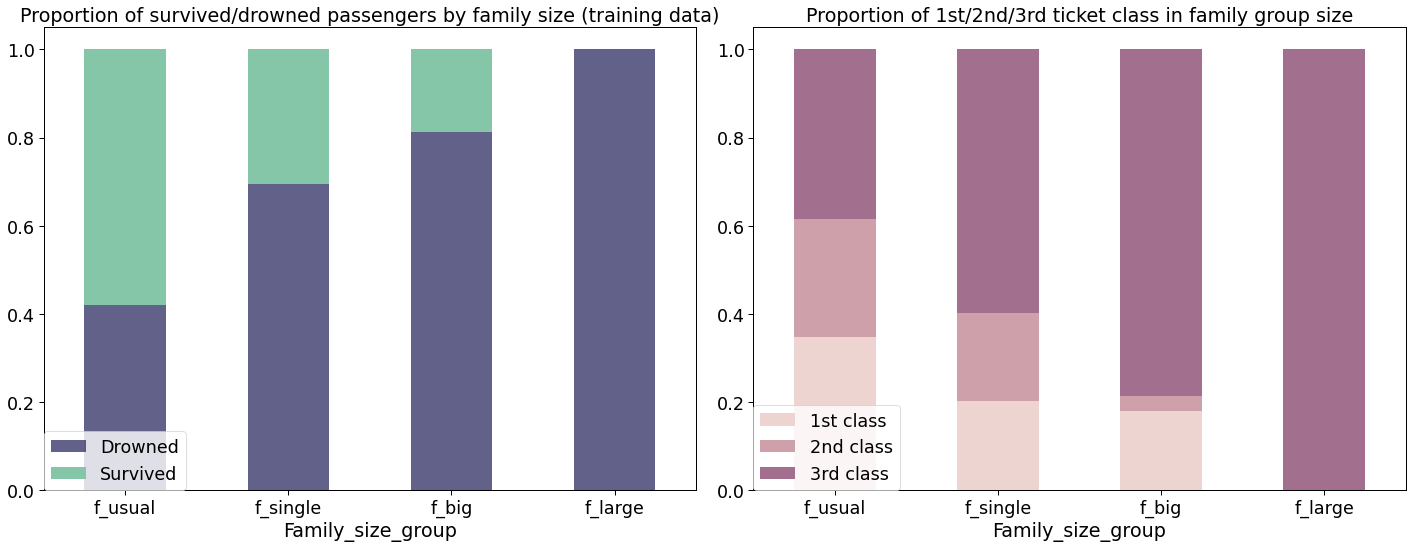

In [32]:
fig = plt.figure(figsize = (20,8))

ax1 = fig.add_subplot(121)
d = all_data.groupby('Family_size_group')['Survived'].value_counts(normalize = True).unstack()
d = d.sort_values(by = 1, ascending = False)
d.plot(kind='bar', stacked='True', color = ["#3f3e6fd1", "#85c6a9"], ax = ax1)
plt.title('Proportion of survived/drowned passengers by family size (training data)')
plt.legend(( 'Drowned', 'Survived'), loc=(0,0))
_ = plt.xticks(rotation=False)


ax2 = fig.add_subplot(122)
d2 = all_data.groupby('Family_size_group')['Pclass'].value_counts(normalize = True).unstack()
d2 = d2.sort_values(by = 1, ascending = False)
d2.plot(kind='bar', stacked='True', color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax2)
plt.legend(('1st class', '2nd class', '3rd class'), loc=(0,0))
plt.title('Proportion of 1st/2nd/3rd ticket class in family group size')
_ = plt.xticks(rotation=False)

plt.tight_layout()

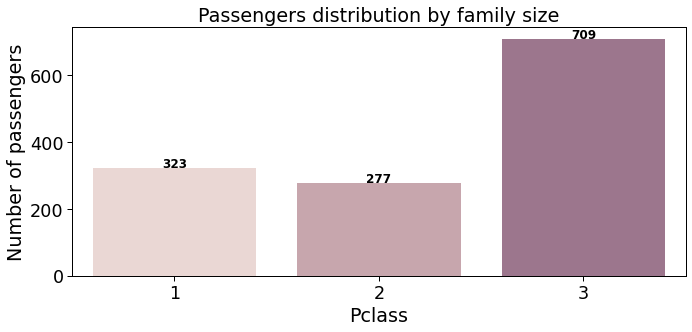

In [33]:
fig = plt.figure(figsize = (10,5))

ax = sns.countplot(all_data['Pclass'], palette = ['#eed4d0', '#cda0aa', '#a2708e'])
# calculate passengers for each category
labels = (all_data['Pclass'].value_counts(sort = False))
# add result numbers on barchart
for i, v in enumerate(labels):
    ax.text(i, v+2, str(v), horizontalalignment = 'center', size = 12, color = 'black', fontweight = 'bold')
    
    
plt.title('Passengers distribution by family size')
plt.ylabel('Number of passengers')
plt.tight_layout()

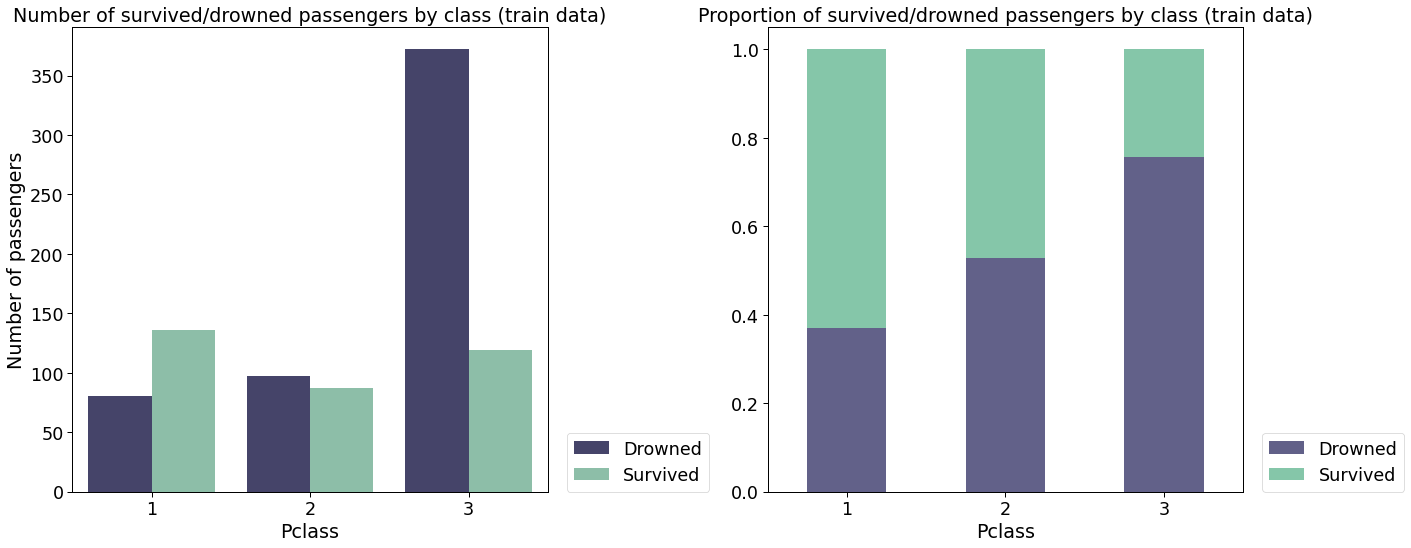

In [34]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(121)
sns.countplot(x = 'Pclass', hue = 'Survived', data = all_data, palette=["#3f3e6fd1", "#85c6a9"], ax = ax1)
plt.title('Number of survived/drowned passengers by class (train data)')
plt.ylabel('Number of passengers')
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
_ = plt.xticks(rotation=False)

ax2 = fig.add_subplot(122)
d = all_data.groupby('Pclass')['Survived'].value_counts(normalize = True).unstack()
d.plot(kind='bar', stacked='True', ax = ax2, color =["#3f3e6fd1", "#85c6a9"])
plt.title('Proportion of survived/drowned passengers by class (train data)')
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
_ = plt.xticks(rotation=False)

plt.tight_layout()

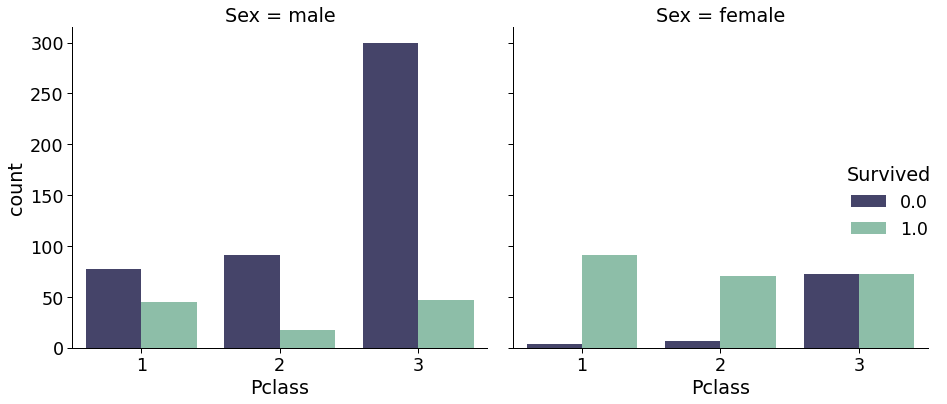

In [35]:
sns.catplot(x = 'Pclass', hue = 'Survived', col = 'Sex', kind = 'count', data = all_data , palette=["#3f3e6fd1", "#85c6a9"], height=6)

plt.tight_layout()

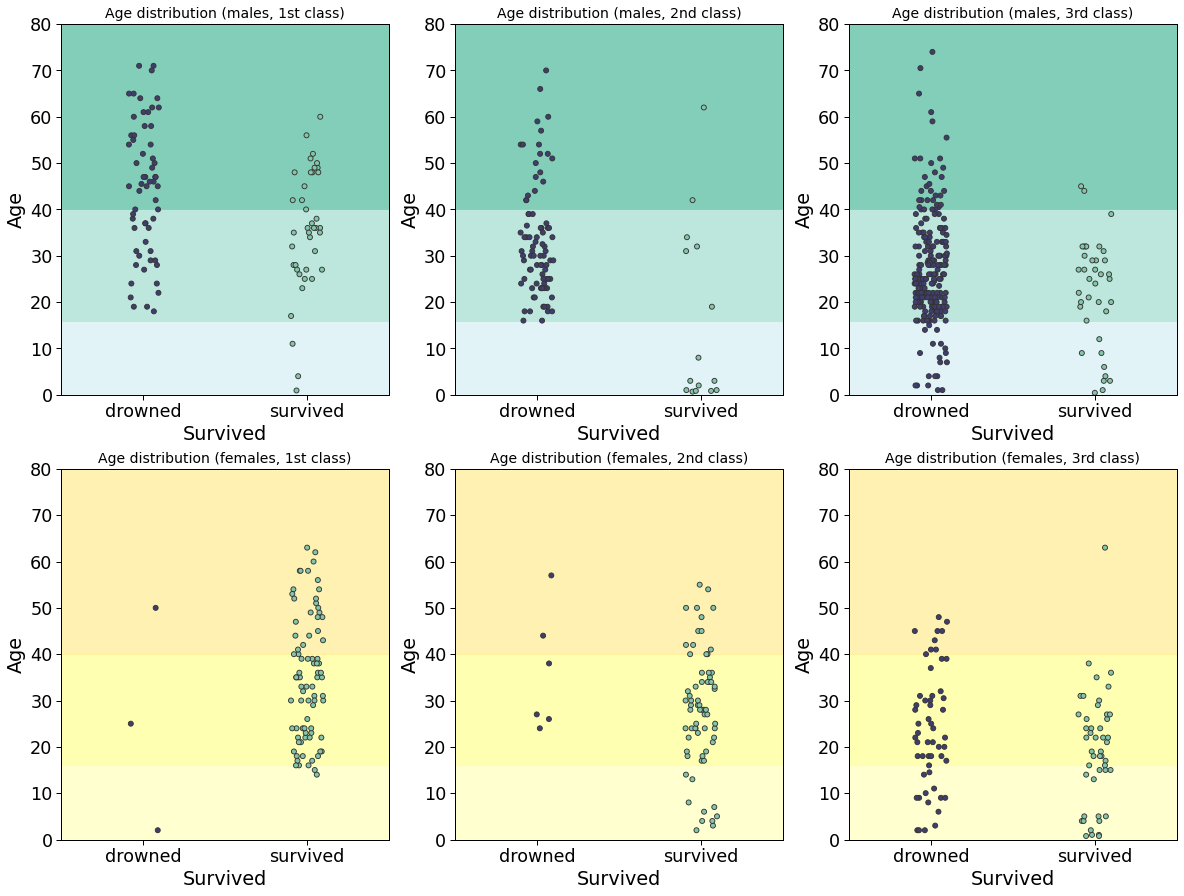

In [36]:
plt.figure(figsize=(20, 15))
palette=["#3f3e6fd1", "#85c6a9"]

plt.subplot(2, 3, 1)
sns.stripplot(x = 'Survived', y = 'Age', data = age_1_class[age_1_class['Sex']=='male'],
     linewidth = 0.9, palette = palette)
plt.axhspan(0, 16, color = "#e1f3f6")
plt.axhspan(16, 40, color = "#bde6dd")
plt.axhspan(40, 80, color = "#83ceb9")
plt.title('Age distribution (males, 1st class)',fontsize= 14)
plt.xticks( np.arange(2), ['drowned', 'survived'])
plt.ylim(0, 80)

plt.subplot(2, 3, 2)
sns.stripplot(x = 'Survived', y = 'Age', data = age_2_class[age_2_class['Sex']=='male'],
     linewidth = 0.9, palette = palette)
plt.axhspan(0, 16, color = "#e1f3f6")
plt.axhspan(16, 40, color = "#bde6dd")
plt.axhspan(40, 80, color = "#83ceb9")
plt.title('Age distribution (males, 2nd class)',fontsize= 14)
plt.xticks( np.arange(2), ['drowned', 'survived'])
plt.ylim(0, 80)

plt.subplot(2, 3, 3)
sns.stripplot(x = 'Survived', y = 'Age', data = age_3_class[age_3_class['Sex']=='male'],
              linewidth = 0.9, palette = palette)
plt.axhspan(0, 16, color = "#e1f3f6")
plt.axhspan(16, 40, color = "#bde6dd")
plt.axhspan(40, 80, color = "#83ceb9")
plt.title('Age distribution (males, 3rd class)',fontsize= 14)
plt.xticks( np.arange(2), ['drowned', 'survived'])
plt.ylim(0, 80)


plt.subplot(2, 3, 4)
sns.stripplot(x = 'Survived', y = 'Age', data = age_1_class[age_1_class['Sex']=='female'],
     linewidth = 0.9, palette = palette)
plt.axhspan(0, 16, color = "#ffff9978")
plt.axhspan(16, 40, color = "#ffff97bf")
plt.axhspan(40, 80, color = "#ffed97bf")
plt.title('Age distribution (females, 1st class)',fontsize= 14)
plt.xticks( np.arange(2), ['drowned', 'survived'])
plt.ylim(0, 80)

plt.subplot(2, 3, 5)
sns.stripplot(x = 'Survived', y = 'Age', data = age_2_class[age_2_class['Sex']=='female'],
     linewidth = 0.9, palette = palette)
plt.axhspan(0, 16, color = "#ffff9978")
plt.axhspan(16, 40, color = "#ffff97bf")
plt.axhspan(40, 80, color = "#ffed97bf")
plt.title('Age distribution (females, 2nd class)',fontsize= 14)
plt.xticks( np.arange(2), ['drowned', 'survived'])
plt.ylim(0, 80)

plt.subplot(2, 3, 6)
sns.stripplot(x = 'Survived', y = 'Age', data = age_3_class[age_3_class['Sex']=='female'],
              linewidth = 0.9, palette = palette)
plt.axhspan(0, 16, color = "#ffff9978")
plt.axhspan(16, 40, color = "#ffff97bf")
plt.axhspan(40, 80, color = "#ffed97bf")
plt.title('Age distribution (females, 3rd class)',fontsize= 14)
plt.xticks( np.arange(2), ['drowned', 'survived'])
plt.ylim(0, 80)


plt.show()

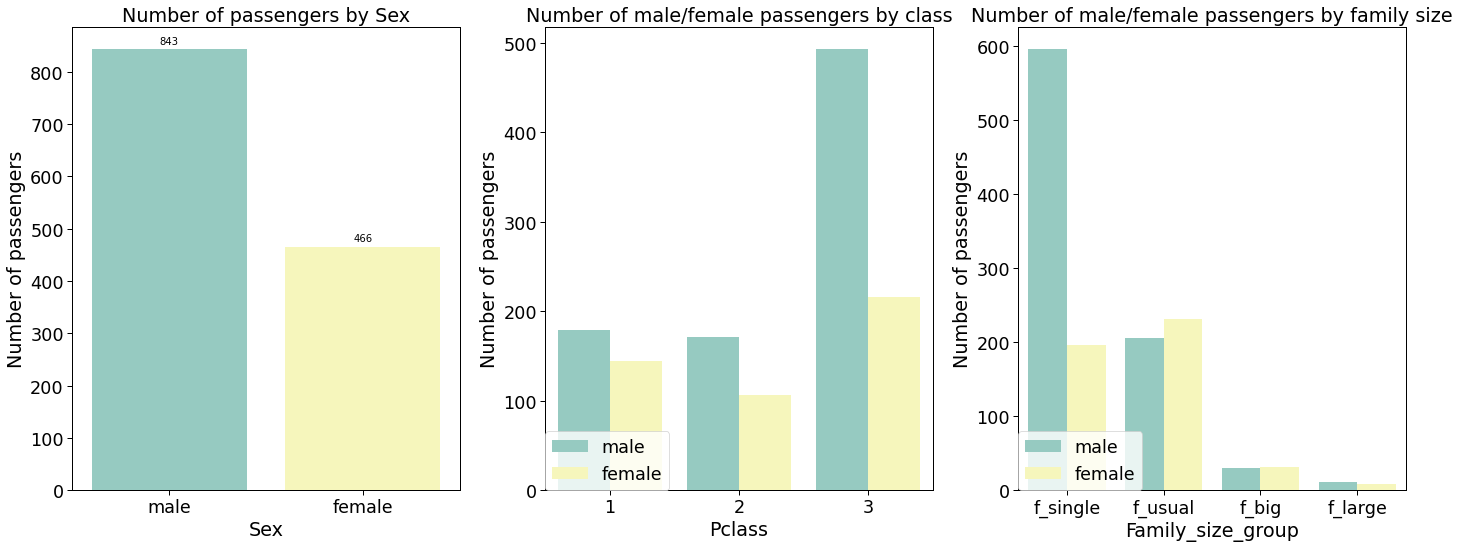

In [37]:
plt.figure(figsize = (20,8))

plt.subplot (1,3,1)
ax = sns.countplot(all_data['Sex'], palette="Set3")
plt.title('Number of passengers by Sex')
plt.ylabel('Number of passengers')

# calculate passengers for each category
labels = (all_data['Sex'].value_counts())
# add result numbers on barchart
for i, v in enumerate(labels):
    ax.text(i, v+10, str(v), horizontalalignment = 'center', size = 10, color = 'black')
    

plt.subplot (1,3,2)
sns.countplot( x = 'Pclass', data = all_data, hue = 'Sex', palette="Set3")
plt.title('Number of male/female passengers by class')
plt.ylabel('Number of passengers')
plt.legend( loc=(0,0))

plt.subplot (1,3,3)
sns.countplot( x = 'Family_size_group', data = all_data, hue = 'Sex', 
              order = all_data['Family_size_group'].value_counts().index , palette="Set3")
plt.title('Number of male/female passengers by family size')
plt.ylabel('Number of passengers')
plt.legend( loc=(0,0))
plt.tight_layout()

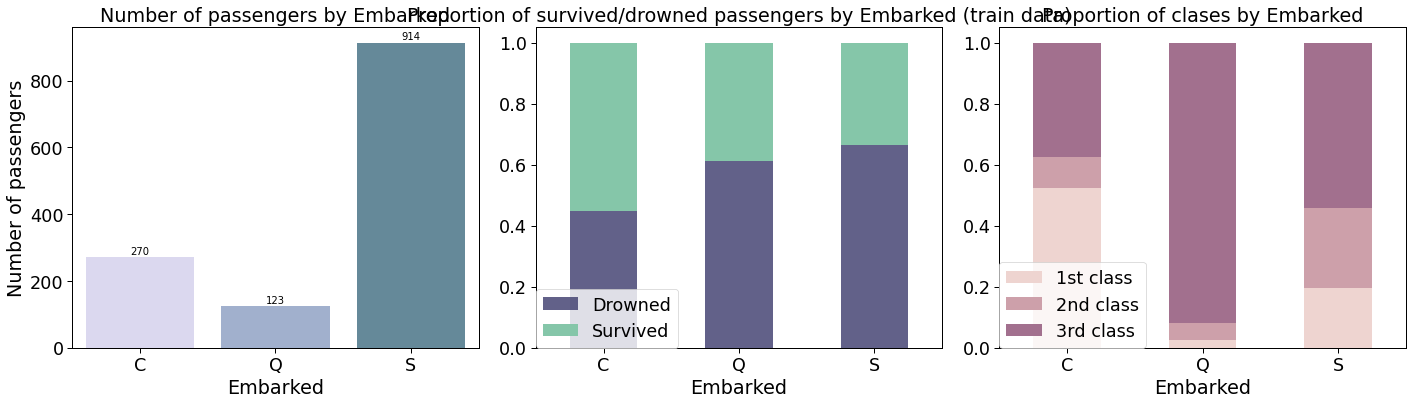

In [38]:
fig = plt.figure(figsize = (20,6))

ax1 = fig.add_subplot(131)
palette = sns.cubehelix_palette(5, start = 2)
ax = sns.countplot(all_data['Embarked'], palette = palette, order = ['C', 'Q', 'S'], ax = ax1)
plt.title('Number of passengers by Embarked')
plt.ylabel('Number of passengers')

# calculate passengers for each category
labels = (all_data['Embarked'].value_counts())
labels = labels.sort_index()
# add result numbers on barchart
for i, v in enumerate(labels):
    ax.text(i, v+10, str(v), horizontalalignment = 'center', size = 10, color = 'black')
    

ax2 = fig.add_subplot(132)
surv_by_emb = all_data.groupby('Embarked')['Survived'].value_counts(normalize = True)
surv_by_emb = surv_by_emb.unstack().sort_index()
surv_by_emb.plot(kind='bar', stacked='True', color=["#3f3e6fd1", "#85c6a9"], ax = ax2)
plt.title('Proportion of survived/drowned passengers by Embarked (train data)')
plt.legend(( 'Drowned', 'Survived'), loc=(0,0))
_ = plt.xticks(rotation=False)


ax3 = fig.add_subplot(133)
class_by_emb = all_data.groupby('Embarked')['Pclass'].value_counts(normalize = True)
class_by_emb = class_by_emb.unstack().sort_index()
class_by_emb.plot(kind='bar', stacked='True', color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax3)
plt.legend(('1st class', '2nd class', '3rd class'), loc=(0,0))
plt.title('Proportion of clases by Embarked')
_ = plt.xticks(rotation=False)

plt.tight_layout()

In [39]:
def feature_generator_first (data, train = False):
    
    features_data = data
    
    
    # Add new variable Age_NA indicates that there is no age in the original data.
    features_data.loc[features_data['Age'].isna(), 'Age_NA'] = 1     # 1 for missing Age value
    features_data.loc[features_data['Age_NA'].isna(), 'Age_NA'] = 0  # 0 if Age value is not null

    # titles categories dict
    title_dict = {  'Mr':     'Mr',
                    'Mrs':    'Mrs',
                    'Miss':   'Miss',
                    'Master': 'Master',              
                    'Ms':     'Miss',
                    'Mme':    'Mrs',
                    'Mlle':   'Miss',
                    'Capt':   'military',
                    'Col':    'military',
                    'Major':  'military',
                    'Dr':     'Dr',
                    'Rev':    'Rev',                  
                    'Sir':    'honor',
                    'the Countess': 'honor',
                    'Lady':   'honor',
                    'Jonkheer': 'honor',
                    'Don':    'honor',
                    'Dona':   'honor' }
    
    # add title variable
    features_data['Title'] = features_data['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0].str.strip(' ')

    # map titles to category
    features_data['Title_category'] = features_data['Title'].map(title_dict)

    # delete Title variable
    del features_data['Title']

    # Filling the missing values in Age with the medians of Sex and Pclass, Title groups
    features_data['Age'] = features_data.groupby(['Pclass', 'Sex', 'Title_category'])['Age'].apply(lambda x: x.fillna(x.median()))
    
    
    
    # Deck
    # Extract deck letter from cabin number
    features_data['deck'] = features_data['Cabin'].str.split('', expand = True)[1]
    # If cabin is NA - deck = U
    features_data.loc[features_data['deck'].isna(), 'deck'] = 'U'
    # If cabin is T - change to A (see EDA)
    features_data.loc[features_data['deck'] == 'T', 'deck'] = 'A'
    # Create dummy variables with prefix 'deck'
    features_data = pd.concat([features_data,
                               pd.get_dummies(features_data['deck'], prefix = 'deck')], 
                               axis=1)
    
    ## Fare tuning:
    features_data['Fare'] = features_data.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))
    
    
    # titles dummy
    features_data = pd.concat([features_data, 
                               pd.get_dummies(features_data['Title_category'],
                                              prefix = 'title')], axis=1)

    # family size
    features_data['Family_size'] = features_data['SibSp'] + features_data['Parch'] + 1
    features_data['Family_size_group'] = features_data['Family_size'].map(
                                            lambda x: 'f_single' if x == 1 
                                                    else ('f_usual' if 5 > x >= 2 
                                                          else ('f_big' if 8 > x >= 5 
                                                               else 'f_large' )))
    features_data = pd.concat([features_data, 
                               pd.get_dummies(features_data['Family_size_group'], 
                                              prefix = 'family')], axis=1)     
    
    
    # Sex to number
    features_data['Sex'] = features_data['Sex'].map({'female': 1, 'male': 0}).astype(int)
    
    # embarked dummy
    features_data = pd.concat([features_data, 
                               pd.get_dummies(features_data['Embarked'], 
                                              prefix = 'embarked')], axis=1)
    
    # zero fare feature
    features_data['zero_fare'] = features_data['Fare'].map(lambda x: 1 if x == 0 else (0))
    
    # from numeric to categorical
    features_data['SibSp'] = features_data['SibSp'].map(lambda x: 1 if x > 0 else (0))
    features_data['Parch'] = features_data['Parch'].map(lambda x: 1 if x > 0 else (0))
    
    # delete variables we are not going to use anymore
    del features_data['PassengerId']
    del features_data['Ticket']
    del features_data['Cabin']
    del features_data['deck']    
    del features_data['Title_category']
    del features_data['Name']
    del features_data['Family_size']
    del features_data['Family_size_group'] 
    del features_data['Embarked']    
    
    return features_data     

In [40]:
def feature_generator_second (data, train = False):
    
    features_data = data
    
    # New Title feature
    features_data['Title'] = features_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    features_data['Title'] = features_data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    features_data['Title'] = features_data['Title'].replace('Mlle', 'Miss')
    features_data['Title'] = features_data['Title'].replace('Ms', 'Miss')
    features_data['Title'] = features_data['Title'].replace('Mme', 'Mrs')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    features_data['Title'] = features_data['Title'].map(title_mapping)
    features_data['Title'] = features_data['Title'].fillna(0)

    ##dropping Name feature
    features_data = features_data.drop(['Name'], axis=1)

    # Convert 'Sex' variable to integer form!
    features_data["Sex"][features_data["Sex"] == "male"] = 0
    features_data["Sex"][features_data["Sex"] == "female"] = 1
    features_data["Sex"] = features_data["Sex"].astype(int)

    ## Age tuning:
    features_data['Age'] = features_data.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    features_data["Age"] = features_data["Age"].astype(int)

    features_data['Age_cat'] = pd.qcut(features_data['Age'],q=[0, .16, .33, .49, .66, .83, 1], labels=False, precision=1)



    # Ticket tuning
    tickets = []
    for i in list(features_data.Ticket):
        if not i.isdigit():
            tickets.append(i.replace(".","").replace("/","").strip().split(" ")[0])
        else:
            tickets.append("x")
    features_data["Ticket"] = tickets
    features_data['Ticket_Frequency'] = features_data.groupby('Ticket')['Ticket'].transform('count')
    features_data = pd.get_dummies(features_data, columns= ["Ticket"], prefix = "T")

    ## Fare tuning:
    features_data['Fare'] = features_data.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median())) 

    features_data['Zero_Fare'] = features_data['Fare'].map(lambda x: 1 if x == 0 else (0))


    def fare_category(fr): 
        if fr <= 7.91:
            return 1
        elif fr <= 14.454 and fr > 7.91:
            return 2
        elif fr <= 31 and fr > 14.454:
            return 3
        return 4

    features_data['Fare_cat'] = features_data['Fare'].apply(fare_category) 

    # Replace missing values with 'U' for Cabin
    features_data['Cabin'] = features_data['Cabin'].fillna('U')
    import re
    # Extract first letter
    features_data['Cabin'] = features_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
    # Mapping 'Cabin' to group
    features_data['Cabin'] = features_data['Cabin'].map(cabin_category)


    features_data["Embarked"] = features_data["Embarked"].fillna("C")
    features_data["Embarked"][features_data["Embarked"] == "S"] = 1
    features_data["Embarked"][features_data["Embarked"] == "C"] = 2
    features_data["Embarked"][features_data["Embarked"] == "Q"] = 3
    features_data["Embarked"] = features_data["Embarked"].astype(int)

    # New 'familySize' feature & dripping 2 features:
    features_data['FamilySize'] = features_data['SibSp'] + features_data['Parch'] + 1


    features_data['FamilySize_cat'] = features_data['FamilySize'].map(lambda x: 1 if x == 1 
                                                                else (2 if 5 > x >= 2 
                                                                      else (3 if 8 > x >= 5 
                                                                           else 4 )
                                                                     ))       

    features_data['Alone'] = [1 if i == 1 else 0 for i in features_data['FamilySize']]




    dummy_col=['Title', 'Sex',  'Age_cat', 'SibSp', 'Parch', 'Fare_cat', 'Embarked', 'Pclass', 'FamilySize_cat']
    dummy = pd.get_dummies(features_data[dummy_col], columns=dummy_col, drop_first=False)
    features_data = pd.concat([dummy, features_data], axis = 1)


    dummy_fare = ['Fare']
    dummy_f = pd.get_dummies(features_data[dummy_fare], columns=dummy_fare, drop_first=True)
    features_data = pd.concat([dummy_f, features_data], axis = 1)

    ## some little dance with features
    features_data['FareCat_Sex'] = features_data['Fare_cat']*features_data['Sex']
    features_data['Pcl_Sex'] = features_data['Pclass']*features_data['Sex']
    features_data['Pcl_Title'] = features_data['Pclass']*features_data['Title']
    features_data['Age_cat_Sex'] = features_data['Age_cat']*features_data['Sex']
    features_data['Age_cat_Pclass'] = features_data['Age_cat']*features_data['Pclass']
    features_data['Title_Sex'] = features_data['Title']*features_data['Sex']

    features_data['SmallF'] = features_data['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
    features_data['Mefeatures_data']   = features_data['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    features_data['LargeF'] = features_data['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
    features_data['Senior'] = features_data['Age'].map(lambda s:1 if s>70 else 0)

    features_data["Fare"] = features_data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
    
    del features_data['deck']    
    del features_data['Title_category']

    # features_data['Rich_woman'] = 0
    # features_data['Men_3Class'] = 0


    # features_data.loc[(features_data['Pclass']<=2) & (features_data['Sex']==0), 'Rich_woman'] = 1
    # features_data.loc[(features_data['Pclass']==3) & (features_data['Sex']==1), 'Men_3Class'] = 1


    # features_data['Rich_woman'] = features_data['Rich_woman'].astype(np.int8)
    return features_data

In [41]:
def feature_generator_third (data, train = False):
    
    features_data = data
    
    # convert Sex into categorical value 0 for male and 1 for female
    features_data["Sex"] = features_data["Sex"].map({"male": 0, "female":1})
    
    #Fill Embarked nan values of dataset set with 'S' most frequent value
    features_data["Embarked"] = features_data["Embarked"].fillna("S")
    
    ## Fare tuning:
    features_data['Fare'] = features_data.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))
    
    
    # Filling missing value of Age 

    ## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
    # Index of NaN age rows
    index_NaN_age = list(features_data["Age"][features_data["Age"].isnull()].index)

    for i in index_NaN_age:
        age_med = features_data["Age"].median()
        age_pred = features_data["Age"][((features_data['SibSp'] == features_data.iloc[i]["SibSp"]) 
                                         & (features_data['Parch'] == features_data.iloc[i]["Parch"]) 
                                         & (features_data['Pclass'] == features_data.iloc[i]["Pclass"]))].median()
        if not np.isnan(age_pred):
            features_data['Age'].iloc[i] = age_pred
        else:
            features_data['Age'].iloc[i] = age_med
            
    #Feature engineering Name/Title
    dataset_title = [i.split(",")[1].split(".")[0].strip() for i in features_data["Name"]]
    features_data["Title"] = pd.Series(dataset_title)
    features_data["Title"] = features_data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    features_data["Title"] = features_data["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
    features_data["Title"] = features_data["Title"].astype(int)
    features_data.drop(labels = ["Name"], axis = 1, inplace = True)
    features_data.drop(labels = ["Title_category"], axis = 1, inplace = True)
    
    #Feature engineering Family size
    # Create a family size descriptor from SibSp and Parch
    features_data["Fsize"] = features_data["SibSp"] + features_data["Parch"] + 1
    # Create new feature of family size
    features_data['Single'] = features_data['Fsize'].map(lambda s: 1 if s == 1 else 0)
    features_data['SmallF'] = features_data['Fsize'].map(lambda s: 1 if  s == 2  else 0)
    features_data['MedF'] = features_data['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    features_data['LargeF'] = features_data['Fsize'].map(lambda s: 1 if s >= 5 else 0)
    
    # convert to indicator values Title and Embarked 
    features_data = pd.get_dummies(features_data, columns = ["Title"])
    features_data = pd.get_dummies(features_data, columns = ["Embarked"], prefix="Em")
    
    #Feature engineering Cabin
    features_data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in features_data['Cabin'] ])
    features_data = pd.get_dummies(features_data, columns = ["Cabin"],prefix="Cabin")
    
    features_data.drop(labels = ["deck"], axis = 1, inplace = True)
    
    #Feature engineering Ticket
    ## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 
    Ticket = []
    for i in list(features_data.Ticket):
        if not i.isdigit() :
            Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
        else:
            Ticket.append("X")
        
    features_data["Ticket"] = Ticket
    
    features_data = pd.get_dummies(features_data, columns = ["Ticket"], prefix="T")
    
    # Create categorical values for Pclass
    features_data["Pclass"] = features_data["Pclass"].astype("category")
    features_data = pd.get_dummies(features_data, columns = ["Pclass"],prefix="Pc")
    
    # Drop useless variables 
    features_data.drop(labels = ["PassengerId"], axis = 1, inplace = True)
    
    return features_data

In [42]:
if 'Survived' in train_data.columns:
    all_train_label = train_data['Survived']
    del train_data['Survived']

In [43]:
# Generate features from training dataset
all_train_features_first = feature_generator_first(train_data)
# Generate features from test dataset
all_test_features_first = feature_generator_first(test_data)

In [44]:
#Reset all changes in all_data
all_data = (pd.concat([train_data, test_data], sort = False).reset_index(drop=True)).copy()
if 'Survived' in all_data.columns:
    del all_data['Survived']

In [45]:
all_data = feature_generator_second(all_data)
# Generate features from training dataset
all_train_features_second = all_data[0:train_data.shape[0]]
# Generate features from test dataset
all_test_features_second = all_data[train_data.shape[0]:]

In [46]:
#Reset all changes in all_data
all_data = (pd.concat([train_data, test_data], sort = False).reset_index(drop=True)).copy()
if 'Survived' in all_data.columns:
    del all_data['Survived']

In [47]:
all_data = feature_generator_third(all_data)
# Generate features from training dataset
all_train_features_third = all_data[0:train_data.shape[0]]
# Generate features from test dataset
all_test_features_third = all_data[train_data.shape[0]:]

In [48]:
print("Shape of first feature generation: {}".format(all_train_features_first.shape))
print("Shape of second feature generation: {}".format(all_train_features_second.shape))
print("Shape of third feature generation: {}".format(all_train_features_third.shape))

Shape of first feature generation: (881, 31)
Shape of second feature generation: (881, 387)
Shape of third feature generation: (881, 67)


In [49]:
reduce_memory_usage(all_train_features_first)
reduce_memory_usage(all_test_features_first)
reduce_memory_usage(all_train_features_second)
reduce_memory_usage(all_test_features_second)
reduce_memory_usage(all_train_features_third)
reduce_memory_usage(all_test_features_third)

Intial memory usage: 0.07321834564208984 MB
Memory usage after complition:  0.03372955322265625 MB
Intial memory usage: 0.03480339050292969 MB
Memory usage after complition:  0.0160675048828125 MB
Intial memory usage: 0.48995113372802734 MB
Memory usage after complition:  0.33199596405029297 MB
Intial memory usage: 0.2325305938720703 MB
Memory usage after complition:  0.15758705139160156 MB
Intial memory usage: 0.1211090087890625 MB
Memory usage after complition:  0.06397628784179688 MB
Intial memory usage: 0.057529449462890625 MB
Memory usage after complition:  0.030422210693359375 MB


In [50]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(all_train_features_first, all_train_label)

x_train_first, x_valid_first, y_train_first, y_valid_first = train_test_split(X_ros, 
                                                                              y_ros, 
                                                                              test_size=0.2, 
                                                                              random_state=10)

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(all_train_features_second, all_train_label)

x_train_second, x_valid_second, y_train_second, y_valid_second = train_test_split(X_ros,
                                                                                  y_ros, 
                                                                                  test_size=0.2, 
                                                                                  random_state=10)

### Logistic regression

In [51]:
# set model. max_iter - Maximum number of iterations taken for the solvers to converge.
lg_model = LogisticRegression(random_state = 64, max_iter = 1000)

# set parameters values we are going to check
optimization_dict = {'class_weight':['balanced', None],
                     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'C': [0.01, 0.05, 0.07, 0.1, 0.5, 1, 2, 4, 5, 10, 15, 20]
                     }
# set GridSearchCV parameters
model = GridSearchCV(lg_model, optimization_dict, 
                     scoring='roc_auc', verbose = 1, n_jobs = -1, cv = 10)

# use training features
model.fit(x_train_first, y_train_first)

# print result
print(model.best_score_)
print(model.best_params_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 692 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  1.5min


0.8724895755047187
{'C': 10, 'class_weight': 'balanced', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.7min finished


In [52]:
# set best parameters to the model
lg_tuned_model_first =  LogisticRegression(solver = model.best_params_['solver'],
                                     C = model.best_params_['C'],
                                     class_weight = None,
                                     random_state = 64,
                                     n_jobs = -1)

# train our model with training data
lg_tuned_model_first.fit(x_train_first, y_train_first)

#eval metrics
y_pred = lg_tuned_model_first.predict(x_valid_first)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid_first, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid_first, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid_first, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid_first, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid_first, y_pred)))

Accuracy :0.78802
AUC : 0.78765
Precision : 0.79646
Recall : 0.79646
F1 : 0.79646


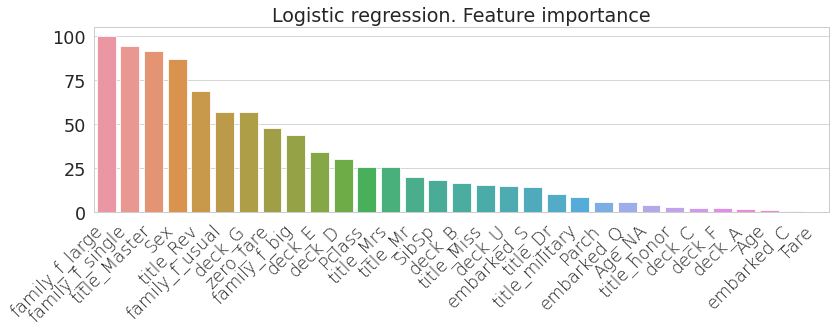

In [53]:
# calculate importances based on coefficients.
importances = abs(lg_tuned_model_first.coef_[0])
importances = 100.0 * (importances / importances.max())
# sort 
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [all_train_features_first.columns[i] for i in indices]

# visualize
plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y = importances[indices])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Logistic regression. Feature importance')
plt.tight_layout()

In [54]:
# set model. max_iter - Maximum number of iterations taken for the solvers to converge.
lg_model = LogisticRegression(random_state = 64, max_iter = 1000)

# set parameters values we are going to check
optimization_dict = {'class_weight':['balanced', None],
                     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'C': [0.01, 0.05, 0.07, 0.1, 0.5, 1, 2, 4, 5, 10, 15, 20]
                     }
# set GridSearchCV parameters
model = GridSearchCV(lg_model, optimization_dict, 
                     scoring='roc_auc', verbose = 1, n_jobs = -1, cv = 10)

# use training features
model.fit(x_train_second, y_train_second)

# print result
print(model.best_score_)
print(model.best_params_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.9min


0.9136392316895293
{'C': 10, 'class_weight': 'balanced', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 15.5min finished


In [55]:
# set best parameters to the model
lg_tuned_model_second =  LogisticRegression(solver = model.best_params_['solver'],
                                     C = model.best_params_['C'],
                                     class_weight = None,
                                     random_state = 64,
                                     n_jobs = -1)

# train our model with training data
lg_tuned_model_second.fit(x_train_second, y_train_second)

#eval metrics
y_pred = lg_tuned_model_second.predict(x_valid_second)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid_second, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid_second, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid_second, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid_second, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid_second, y_pred)))

Accuracy :0.85714
AUC : 0.85479
Precision : 0.83065
Recall : 0.91150
F1 : 0.86920


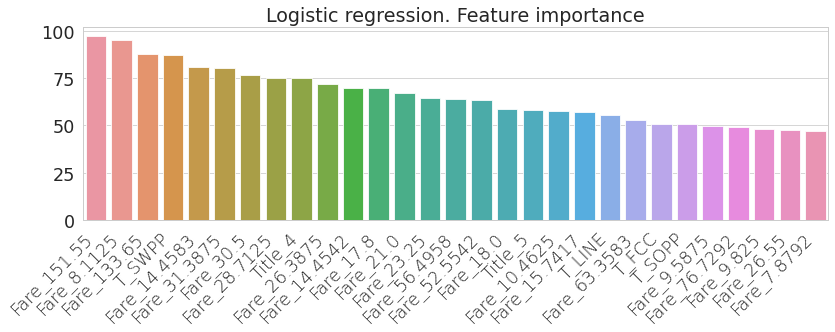

In [56]:
# calculate importances based on coefficients.
importances = abs(lg_tuned_model_second.coef_[0])
importances = 100.0 * (importances / importances.max())
# sort 
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [all_train_features_second.columns[i] for i in indices[1:30]]

# visualize
plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y = importances[indices[1:30]])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Logistic regression. Feature importance')
plt.tight_layout()

### Random forest

In [57]:
# set model
rf_model = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state = 64)
# create a dictionary of parameters values we want to try
optimization_dict = {'criterion':['gini', 'entropy'],
                     'n_estimators': [100, 500, 1000, 1700], #[100, 500],
                     'max_depth': [7, 10, 11, 12], #[7, 10],
                     'min_samples_split': [6, 7, 8, 10], #[6, 7],
                     'min_samples_leaf':  [3, 4, 5] #[3, 4]
                     }

# set GridSearchCV parameters
model = GridSearchCV(rf_model, optimization_dict, 
                     scoring='roc_auc', verbose = 1, n_jobs = -1, cv = 5)

# use training data
model.fit(x_train_first, y_train_first)

# print best score and best parameters combination
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 30.3min finished


0.8878666839630801
{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 500}


In [58]:
# set best parameters to the model
rf_tuned_model_first =  RandomForestClassifier(criterion = model.best_params_['criterion'],
                                       n_estimators = model.best_params_['n_estimators'],
                                       max_depth = model.best_params_['max_depth'],
                                       min_samples_split = model.best_params_['min_samples_split'],
                                       min_samples_leaf = model.best_params_['min_samples_leaf'],
                                       max_features = 'auto',
                                       oob_score = True,
                                       random_state = 64,
                                       n_jobs = -1)

# train our model with training data
rf_tuned_model_first.fit(x_train_first, y_train_first)

#eval metrics
y_pred = rf_tuned_model_first.predict(x_valid_first)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid_first, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid_first, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid_first, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid_first, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid_first, y_pred)))

Accuracy :0.82028
AUC : 0.81978
Precision : 0.82456
Recall : 0.83186
F1 : 0.82819


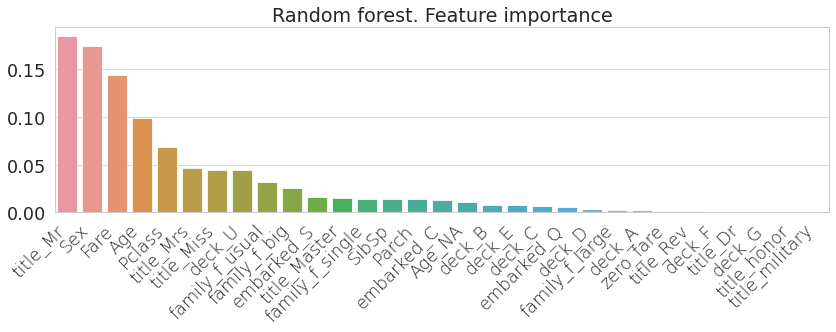

In [59]:
# Calculate feature importances
importances = rf_tuned_model_first.feature_importances_

# Visualize Feature Importance
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [all_train_features_first.columns[i] for i in indices]

plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y=importances[indices])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Random forest. Feature importance')
plt.tight_layout()

In [60]:
# set model
rf_model = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state = 64)
# create a dictionary of parameters values we want to try
optimization_dict = {'criterion':['gini', 'entropy'],
                     'n_estimators': [100, 500, 1000, 1700], #[100, 500],
                     'max_depth': [7, 10, 11, 12], #[7, 10],
                     'min_samples_split': [6, 7, 8, 10], #[6, 7],
                     'min_samples_leaf':  [3, 4, 5] #[3, 4]
                     }

# set GridSearchCV parameters
model = GridSearchCV(rf_model, optimization_dict, 
                     scoring='roc_auc', verbose = 1, n_jobs = -1, cv = 5)

# use training data
model.fit(x_train_second, y_train_second)

# print best score and best parameters combination
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 36.2min finished


0.8893510128408
{'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1700}


In [61]:
# set best parameters to the model
rf_tuned_model_second =  RandomForestClassifier(criterion = model.best_params_['criterion'],
                                       n_estimators = model.best_params_['n_estimators'],
                                       max_depth = model.best_params_['max_depth'],
                                       min_samples_split = model.best_params_['min_samples_split'],
                                       min_samples_leaf = model.best_params_['min_samples_leaf'],
                                       max_features = 'auto',
                                       oob_score = True,
                                       random_state = 64,
                                       n_jobs = -1)

# train our model with training data
rf_tuned_model_second.fit(x_train_second, y_train_second)

#eval metrics
y_pred = rf_tuned_model_second.predict(x_valid_second)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid_second, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid_second, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid_second, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid_second, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid_second, y_pred)))

Accuracy :0.80645
AUC : 0.80650
Precision : 0.81982
Recall : 0.80531
F1 : 0.81250


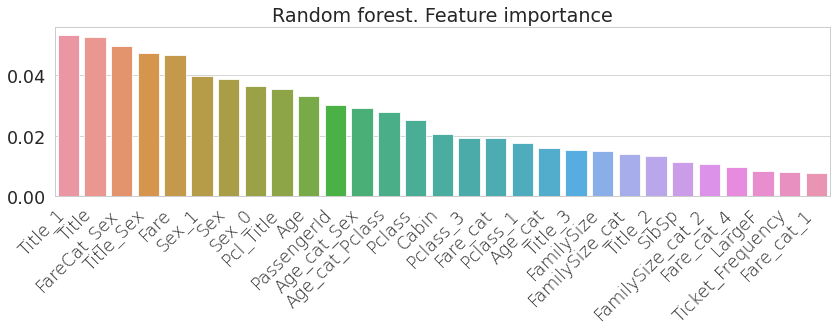

In [62]:
# Calculate feature importances
importances = rf_tuned_model_second.feature_importances_

# Visualize Feature Importance
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [all_train_features_second.columns[i] for i in indices[1:30]]

plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y=importances[indices[1:30]])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Random forest. Feature importance')
plt.tight_layout()

### XGBoost

In [63]:
# set model
xgb_model = XGBClassifier(random_state = 64, eval_metric='auc')
# create a dictionary of parameters values we want to try
optimization_dict = {'n_estimators': [200, 1000, 1700],
                     'max_depth': [4, 6],
                     'learning_rate': [0.001, 0.01, 0.05],
                     'gamma': [0, 1],
                     'min_child_weight': [3, 6, 10],
                     'subsample': [0.5, 0.8]
                     }
# set GridSearchCV parameters
model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='roc_auc', verbose = 1, n_jobs = -1, cv = 5)

# use training data
model.fit(x_train_first, y_train_first)
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 35.4min finished


0.9079843889148573
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1000, 'subsample': 0.5}


In [64]:
# set model with best parameters
xgb_tuned_model_first =  XGBClassifier(n_estimators = model.best_params_['n_estimators'],
                               max_depth = model.best_params_['max_depth'],
                               learning_rate = model.best_params_['learning_rate'],
                               gamma = model.best_params_['gamma'],
                               min_child_weight = model.best_params_['min_child_weight'],
                               subsample = model.best_params_['subsample'],
                               random_state = 64)

# train our model with training data
xgb_tuned_model_first.fit(x_train_first, y_train_first)

#eval metrics
y_pred = xgb_tuned_model_first.predict(x_valid_first)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid_first, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid_first, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid_first, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid_first, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid_first, y_pred)))

[14:54:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy :0.85714
AUC : 0.85479
Precision : 0.83065
Recall : 0.91150
F1 : 0.86920


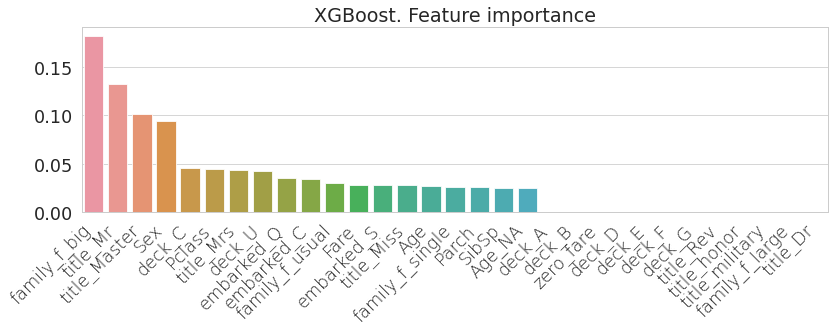

In [65]:
# Calculate feature importances
importances = xgb_tuned_model_first.feature_importances_

# Visualize Feature Importance
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [all_train_features_first.columns[i] for i in indices]

plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y=importances[indices])
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light')
plt.title('XGBoost. Feature importance')
plt.tight_layout()

In [66]:
# set model
xgb_model = XGBClassifier(random_state = 64, eval_metric='auc')
# create a dictionary of parameters values we want to try
optimization_dict = {'n_estimators': [200, 1000, 1700],
                     'max_depth': [4, 6],
                     'learning_rate': [0.001, 0.01, 0.05],
                     'gamma': [0, 1],
                     'min_child_weight': [3, 6, 10],
                     'subsample': [0.5, 0.8]
                     }
# set GridSearchCV parameters
model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='roc_auc', verbose = 1, n_jobs = -1, cv = 5)

# use training data
model.fit(x_train_second, y_train_second)
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 61.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 102.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 137.3min finished


0.9196121743878715
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1700, 'subsample': 0.8}


In [67]:
# set model with best parameters
xgb_tuned_model_second =  XGBClassifier(n_estimators = model.best_params_['n_estimators'],
                               max_depth = model.best_params_['max_depth'],
                               learning_rate = model.best_params_['learning_rate'],
                               gamma = model.best_params_['gamma'],
                               min_child_weight = model.best_params_['min_child_weight'],
                               subsample = model.best_params_['subsample'],
                               random_state = 64)

# train our model with training data
xgb_tuned_model_second.fit(x_train_second, y_train_second)

#eval metrics
y_pred = xgb_tuned_model_second.predict(x_valid_second)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid_second, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid_second, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid_second, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid_second, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid_second, y_pred)))

[17:11:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy :0.86175
AUC : 0.85807
Precision : 0.81679
Recall : 0.94690
F1 : 0.87705


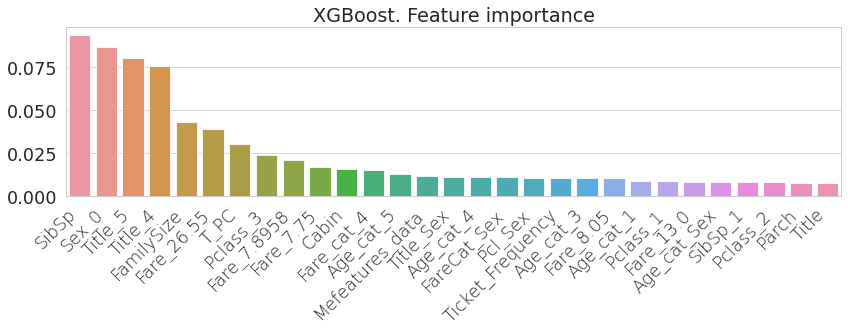

In [68]:
# Calculate feature importances
importances = xgb_tuned_model_second.feature_importances_

# Visualize Feature Importance
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [all_train_features_second.columns[i] for i in indices[1:30]]

plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y=importances[indices[1:30]])
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light')
plt.title('XGBoost. Feature importance')
plt.tight_layout()



In [69]:
lg_tuned_model_second.fit(all_train_features_second, all_train_label)

# get predictions on test dataset
predictions = lg_tuned_model_second.predict(all_test_features_second)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_lg_second_all.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [70]:
xgb_tuned_model_second.fit(all_train_features_second, all_train_label)

# get predictions on test dataset
predictions = xgb_tuned_model_second.predict(all_test_features_second)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_xgb_second_all.csv', index=False)
output.head()

[17:11:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [71]:
lg_tuned_model_first.fit(all_train_features_first, all_train_label)

# get predictions on test dataset
predictions = lg_tuned_model_first.predict(all_test_features_first)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_lg_first_all_outliers.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [72]:
xgb_tuned_model_first.fit(all_train_features_first, all_train_label)

# get predictions on test dataset
predictions = xgb_tuned_model_first.predict(all_test_features_first)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_xgb_first_all_outliers.csv', index=False)
output.head()

[17:12:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [73]:
d_train = xgb.DMatrix(x_train_second, label=y_train_second)
d_valid = xgb.DMatrix(x_valid_second, label=y_valid_second)
d_test = xgb.DMatrix(all_test_features_second)

params = {
        'objective':'binary:hinge',
        'max_depth':13,
        'learning_rate':0.05,
        'eval_metric':'auc',
        'min_child_weight':1,
        'subsample':0.64,
        'colsample_bytree':0.4,
        'seed':29,
        'reg_lambda':2.79,
        'reg_alpha':0.1,
        'gamma':0,
        'scale_pos_weight':1.68,
        'n_estimators': 600,
        'nthread':-1
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
nrounds=10000  
model_extra = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=350, 
                        maximize=True, verbose_eval=10)

[17:12:08] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-auc:0.50000	valid-auc:0.50000
[2]	train-auc:0.50000	valid-auc:0.50000
[3]	train-auc:0.50000	valid-auc:0.50000
[4]	train-auc:0.50000	valid-auc:0.50000
[5]	train-auc:0.50000	valid-auc:0.50000
[6]	train-auc:0.50000	valid-auc:0.50000
[7]	train-auc:0.50000	valid-auc:0.50000
[8]	train-auc:0.50000	valid-auc:0.50000
[9]	train-auc:0.50000	valid-auc:0.50000
[11]	train-auc:0.50000	valid-auc:0.50000
[12]	train-auc:0.64874	valid-auc:0.63019
[13]	train-auc:0.71854	valid-auc:0.66865
[14]	train-auc:0.78261	valid-auc:0.71192
[15]	train-auc:0.81233	valid-auc:0.74557
[16]	train-auc:0.83059	valid-auc:0.76000
[17]	train-auc:0.84771	valid-auc:0.76961
[18

[212]	train-auc:0.99425	valid-auc:0.87692
[213]	train-auc:0.99425	valid-auc:0.88172
[214]	train-auc:0.99425	valid-auc:0.87692
[215]	train-auc:0.99425	valid-auc:0.88172
[216]	train-auc:0.99425	valid-auc:0.88134
[217]	train-auc:0.99540	valid-auc:0.88134
[218]	train-auc:0.99425	valid-auc:0.88134
[219]	train-auc:0.99540	valid-auc:0.87692
[221]	train-auc:0.99540	valid-auc:0.88615
[222]	train-auc:0.99540	valid-auc:0.88615
[223]	train-auc:0.99540	valid-auc:0.87653
[224]	train-auc:0.99654	valid-auc:0.88172
[225]	train-auc:0.99654	valid-auc:0.88134
[226]	train-auc:0.99769	valid-auc:0.87692
[227]	train-auc:0.99769	valid-auc:0.88172
[228]	train-auc:0.99654	valid-auc:0.87692
[229]	train-auc:0.99769	valid-auc:0.87730
[231]	train-auc:0.99769	valid-auc:0.87692
[232]	train-auc:0.99769	valid-auc:0.87692
[233]	train-auc:0.99769	valid-auc:0.87692
[234]	train-auc:0.99769	valid-auc:0.87653
[235]	train-auc:0.99769	valid-auc:0.87692
[236]	train-auc:0.99769	valid-auc:0.87211
[237]	train-auc:0.99769	valid-auc:

[429]	train-auc:0.99886	valid-auc:0.88691
[431]	train-auc:0.99886	valid-auc:0.88691
[432]	train-auc:0.99886	valid-auc:0.88691
[433]	train-auc:0.99886	valid-auc:0.88691
[434]	train-auc:0.99886	valid-auc:0.88691
[435]	train-auc:0.99886	valid-auc:0.88691
[436]	train-auc:0.99886	valid-auc:0.88691
[437]	train-auc:0.99886	valid-auc:0.88691
[438]	train-auc:0.99886	valid-auc:0.88691
[439]	train-auc:0.99886	valid-auc:0.88691
[441]	train-auc:0.99886	valid-auc:0.88691
[442]	train-auc:0.99886	valid-auc:0.88691
[443]	train-auc:0.99886	valid-auc:0.88691
[444]	train-auc:0.99886	valid-auc:0.88691
[445]	train-auc:0.99886	valid-auc:0.88691
[446]	train-auc:0.99886	valid-auc:0.88691
[447]	train-auc:0.99886	valid-auc:0.88691
[448]	train-auc:0.99886	valid-auc:0.88691
[449]	train-auc:0.99886	valid-auc:0.88691
[451]	train-auc:0.99886	valid-auc:0.88691
[452]	train-auc:0.99886	valid-auc:0.88691
[453]	train-auc:0.99886	valid-auc:0.88691
[454]	train-auc:0.99886	valid-auc:0.88691
[455]	train-auc:0.99886	valid-auc:

[647]	train-auc:1.00000	valid-auc:0.87768
[648]	train-auc:1.00000	valid-auc:0.87768
[649]	train-auc:1.00000	valid-auc:0.87768
[651]	train-auc:1.00000	valid-auc:0.87768
[652]	train-auc:1.00000	valid-auc:0.87768
[653]	train-auc:1.00000	valid-auc:0.87768
[654]	train-auc:1.00000	valid-auc:0.87768
[655]	train-auc:1.00000	valid-auc:0.88211
[656]	train-auc:1.00000	valid-auc:0.88211
[657]	train-auc:1.00000	valid-auc:0.88211
[658]	train-auc:1.00000	valid-auc:0.88211
[659]	train-auc:1.00000	valid-auc:0.88211
[661]	train-auc:1.00000	valid-auc:0.88211
[662]	train-auc:1.00000	valid-auc:0.88211
[663]	train-auc:1.00000	valid-auc:0.88211
[664]	train-auc:1.00000	valid-auc:0.88211
[665]	train-auc:1.00000	valid-auc:0.88211
[666]	train-auc:1.00000	valid-auc:0.87768
[667]	train-auc:1.00000	valid-auc:0.88211
[668]	train-auc:1.00000	valid-auc:0.88249
[669]	train-auc:1.00000	valid-auc:0.88211
[671]	train-auc:1.00000	valid-auc:0.88211
[672]	train-auc:1.00000	valid-auc:0.88211
[673]	train-auc:1.00000	valid-auc:

In [74]:
y_pred = model_extra.predict(d_valid)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid_second, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid_second, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid_second, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid_second, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid_second, y_pred)))

Accuracy :0.88018
AUC : 0.87730
Precision : 0.84252
Recall : 0.94690
F1 : 0.89167


In [75]:
# get predictions on test dataset
predictions = model_extra.predict(d_test)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': np.where(predictions<0.8,0,1)})
output.to_csv('submission_model_extra_part.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [76]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [77]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2,5,20,50,100],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="roc_auc", n_jobs= -1, verbose = 1)

gsadaDTC.fit(all_train_features_third, all_train_label)

ada_best = gsadaDTC.best_estimator_

# Best score
gsadaDTC.best_score_

Fitting 10 folds for each of 336 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 1372 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2214 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3156 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed:  3.8min finished


0.8596019013666073

In [78]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None, 2, 10],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10, 15],
              "min_samples_leaf": [1, 3, 10, 15],
              "bootstrap": [False, True],
              "n_estimators" :[100,300,1000],
              "criterion": ["gini", "entropy"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(all_train_features_third, all_train_label)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 34.3min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 48.7min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

0.8388151174668028

In [79]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None, 2, 6, 10],
              "max_features": [1, 3, 10,'auto'],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False, True],
              "n_estimators" :[100, 300, 1000],
              "criterion": ['gini', 'entropy']}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(all_train_features_third, all_train_label)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

0.8410750766087844

In [80]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ['deviance', 'exponential'],
              'n_estimators' : [100,200,300,600,1000],
              'learning_rate': [0.1, 0.05, 0.01, 0.001],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(all_train_features_third, all_train_label)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1262 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2462 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:  8.6min finished


0.8411133810010215

In [81]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': [ 'poly', 'rbf', 'sigmoid'], 
                  'gamma': ['scale', 0.001, 0.003],
                  'C': [1, 30, 100, 200]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(all_train_features_third, all_train_label)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 91.3min finished


0.8183350357507659

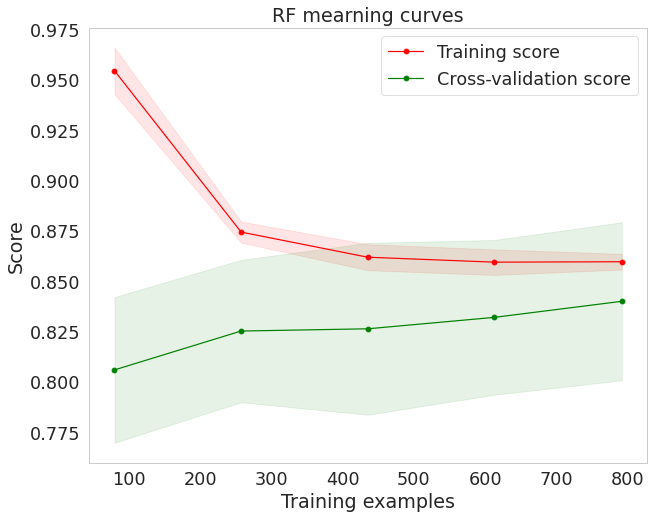

In [82]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",all_train_features_third, all_train_label,cv=kfold)

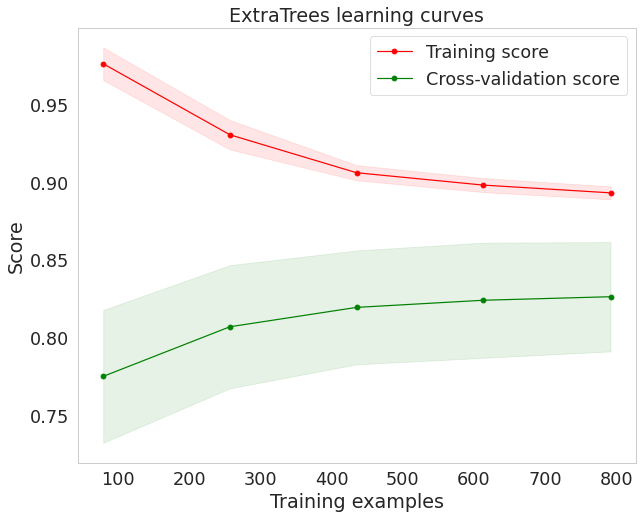

In [83]:
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",all_train_features_third, all_train_label,cv=kfold)

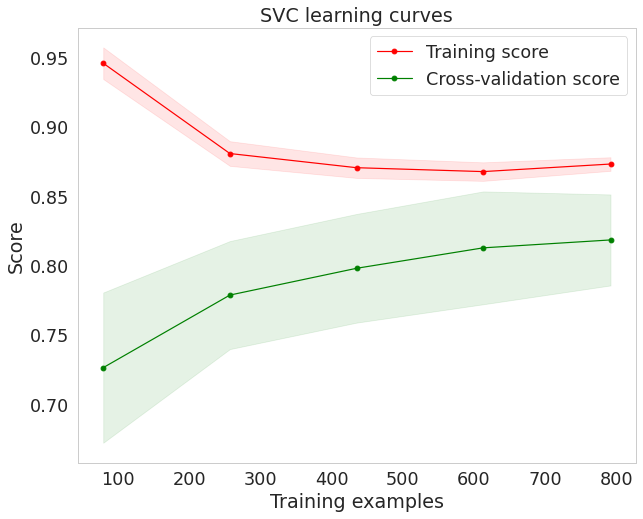

In [84]:
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",all_train_features_third, all_train_label,cv=kfold)

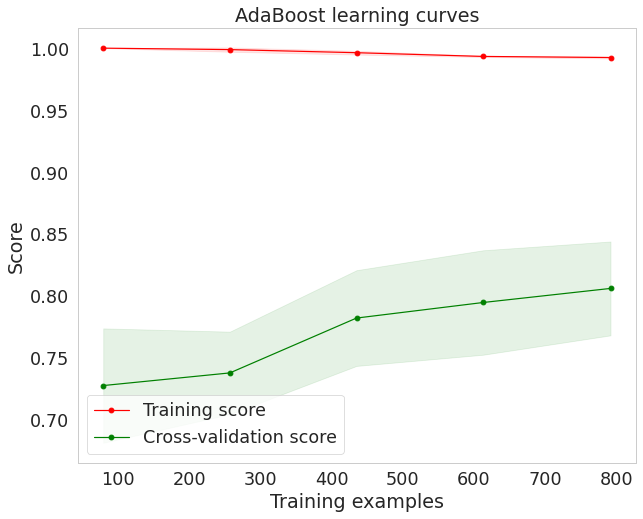

In [85]:
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",all_train_features_third, all_train_label,cv=kfold)

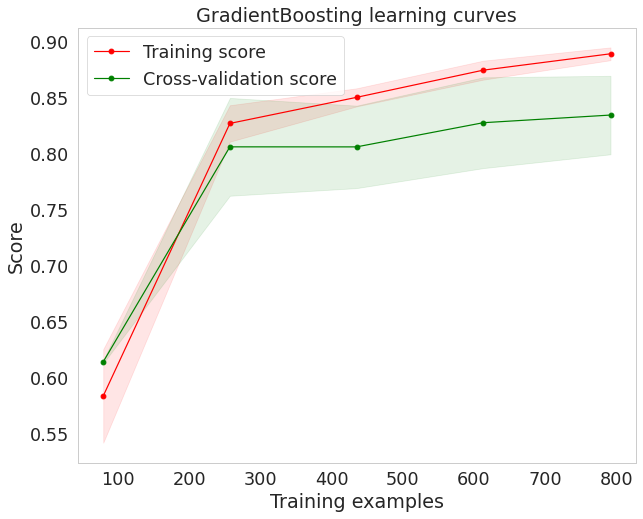

In [86]:
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",all_train_features_third, all_train_label,cv=kfold)

In [87]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(all_train_features_third, all_train_label)

In [88]:
# get predictions on test dataset
predictions = votingC.predict(all_test_features_third)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_ensamble_third_part.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [89]:
voting_second = VotingClassifier(estimators=[('lg', lg_tuned_model_second), 
                                             ('rf', rf_tuned_model_second),
                                             ('xgb', xgb_tuned_model_second)], 
                                             voting='soft', n_jobs=-1)

voting_second = votingC.fit(x_train_second, y_train_second)

In [90]:
# get predictions on test dataset
predictions = voting_second.predict(all_test_features_second)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_ensamble_2_second_part.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [91]:
voting_first = VotingClassifier(estimators=[('lg', lg_tuned_model_first), 
                                             ('rf', rf_tuned_model_first),
                                             ('xgb', xgb_tuned_model_first)], 
                                             voting='soft', n_jobs=-1)

voting_first = votingC.fit(x_train_first, y_train_first)

In [92]:
# get predictions on test dataset
predictions = voting_first.predict(all_test_features_first)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_ensamble_1_second_part.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
